In [1]:
import os
import time

from tqdm import tqdm
import numpy as np
import wandb
from matplotlib import pyplot as plt
import torch
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision import transforms

from my_utils import data, models
from my_utils.utils import Hook, load_model, get_conv_weights, get_feature_maps, get_avg_embeds, check_accuracy
from my_utils.vis import vis_4D, vis_4D_plot, sim_matrix, vis_head


# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:1" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:1 now!


In [153]:
ckpt_name = 'best'
model = load_model(run_name='2022_06_06_02_14_42',
                   log_root='/home/wangyh/01-Projects/03-my/my_final_1',
                   ckpt_name=ckpt_name).to(device)
# conv_weights = get_conv_weights(model)
# print(conv_weights[0].shape)

Loading model parameters ...
best val acc is: 0.9225000143051147
Successfully load model parameters!


In [154]:
conv_weights = get_conv_weights(model)
conv_weights[-1].transpose(1,0,2,3).shape

(4, 8, 5, 5)

In [6]:
array = sim_matrix(data=conv_weights[3].transpose(1,0,2,3), title=ckpt_name, return_mode='fig_array')

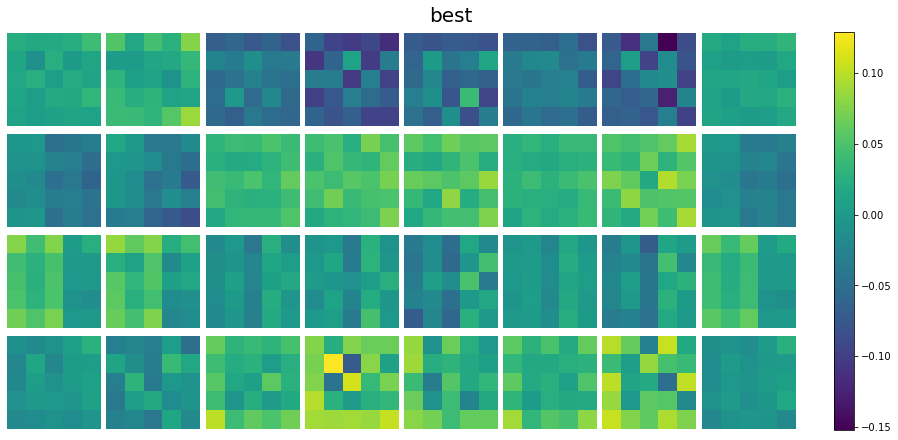

In [155]:
fig = vis_4D_plot(data=conv_weights[3].transpose(1,0,2,3), title=ckpt_name, return_mode='plt_fig', figsize_factor=1.5, tune_factor=0.4, fontsize=20)

In [29]:
fig_dir = f'/home/wangyh/01-Projects/03-my/figures/baseline'
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, f'{ckpt_name}.png')
fig.savefig(fig_path, bbox_inches='tight')

In [ ]:
model_name = 'baseline'
fig_dir = os.path.join('/home/wangyh/01-Projects/03-my/figures/kernel', model_name)
os.makedirs(fig_dir, exist_ok=True)
tune_factors = [0, 0.1, 0.6, 0.4]
fontsizes = [12, 18, 24, 20 ]
for ckpt_name in ['epoch_5', 'epoch_15']:
    model = load_model(run_name='2022_06_06_06_51_25',
                   log_root='/home/wangyh/01-Projects/03-my/my_final_1',
                   ckpt_name=ckpt_name).to(device)
    conv_weights = get_conv_weights(model)
    for fm_idx in [0, 1, 2, 3]:
        fig = vis_4D(data=conv_weights[fm_idx].transpose(1, 0, 2, 3), title=ckpt_name, return_mode='plt_fig',
                     figsize_factor=1.5, tune_factor=tune_factors[fm_idx], fontsize=fontsizes[fm_idx])
        fig_path = os.path.join(fig_dir, f'{ckpt_name}_cw{fm_idx}.png')
        fig.savefig(fig_path, bbox_inches='tight')
        plt.close(fig)


In [145]:
mask_type = 'edge'
mask_rate = 0.02
# Dataset_DIR = f'/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3_{mask_type}_{mask_rate}'
Dataset_DIR = f'/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'
T = transforms.Compose([
    transforms.ToTensor()
])
vis_data = data.MyDataset(os.path.join(Dataset_DIR, 'vis'), transform=T)
vis_loader = DataLoader(vis_data, batch_size=len(vis_data))

In [129]:
imgs, labels = next(iter(vis_loader))
print(imgs.shape)
print(labels)

torch.Size([8, 1, 64, 64])
tensor([0, 0, 1, 1, 2, 2, 3, 3])


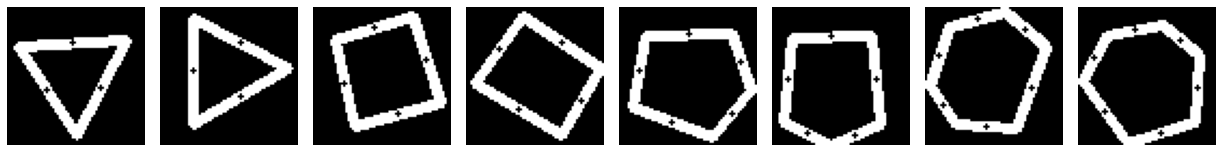

In [130]:
fig = vis_4D_plot(data=imgs.permute(1, 0, 2, 3), figsize_factor=2, cmap='gray', return_mode='plt_fig', tune_factor=1)

In [127]:
fig.savefig(f'/home/wangyh/01-Projects/03-my/figures/vis_fill.png', bbox_inches='tight')

In [131]:
test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
print(len(test_data))
test_loader = DataLoader(test_data, batch_size=2000)
cmatrix = check_accuracy(test_model=model, loader=test_loader)

8000
Test accuracy is : 84.88%	Infer time: 1.364220380783081


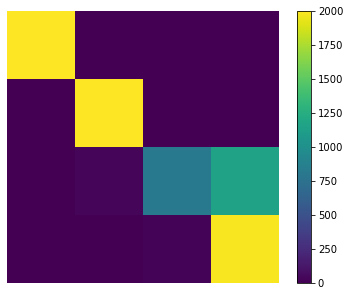

In [132]:
cfig, ax = plt.subplots(1, 1, constrained_layout=True)
im = ax.imshow(cmatrix)
ax.set_axis_off()
fig.colorbar(im, ax=ax, orientation='vertical')

In [120]:
cfig.savefig(f'/home/wangyh/01-Projects/03-my/figures/baseline/confusion_matrix/{mask_type}_{mask_rate}.png', bbox_inches='tight')

In [156]:
images, lables = next(iter(vis_loader))
images = images.to(device)
lables = lables.to(device)
fmaps = get_feature_maps(model.to('cuda:1'), (images, lables))

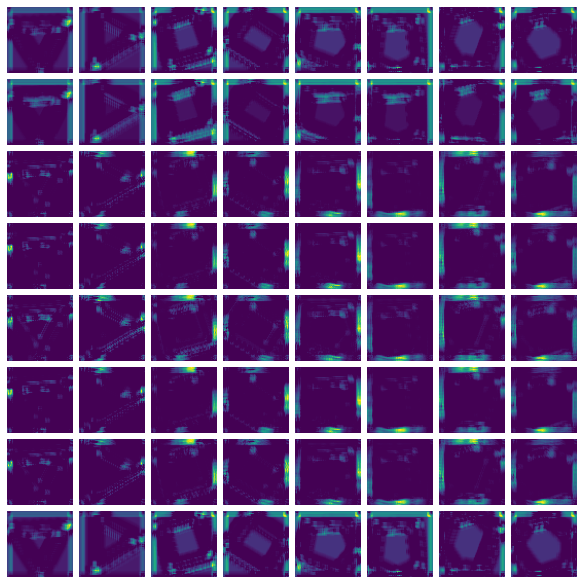

In [161]:
fig = vis_4D_plot(data=fmaps[3].transpose(1,0,2,3), title=None, return_mode='plt_fig', figsize_factor=1, tune_factor=0, fontsize=16, norm=False)

In [162]:
fig.savefig(f'/home/wangyh/01-Projects/03-my/figures/ks/5_fmap.png', bbox_inches='tight')

In [44]:
model_name = 'baseline'
fig_dir = f'/home/wangyh/01-Projects/03-my/figures/{model_name}/feature_maps'
os.makedirs(fig_dir, exist_ok=True)
tune_factors = [-1, -0.4, -0.6, -0.2]
# fontsizes = [16, 18, 18, 20]
for ckpt_name in ['epoch_5', 'epoch_15', 'epoch_30', 'best']:
    model = load_model(run_name='2022_06_06_06_51_25',
                   log_root='/home/wangyh/01-Projects/03-my/my_final_1',
                   ckpt_name=ckpt_name).to(device)
    fmaps = get_feature_maps(model.to('cuda:3'), (images, lables))
    for fm_idx in [0, 1, 2, 3]:
        fig = vis_4D_plot(data=fmaps[fm_idx].transpose(1, 0, 2, 3), title=ckpt_name, return_mode='plt_fig',
                          figsize_factor=1, tune_factor=tune_factors[fm_idx], fontsize=16, norm=False)
        fig_path = os.path.join(fig_dir, f'{ckpt_name}_fm{fm_idx}.png')
        fig.savefig(fig_path, bbox_inches='tight')
        plt.close(fig)

Loading model parameters ...
best val acc is: 0.5442500114440918
Successfully load model parameters!
Loading model parameters ...
best val acc is: 0.7110000252723694
Successfully load model parameters!
Loading model parameters ...
best val acc is: 0.9140000343322754
Successfully load model parameters!
Loading model parameters ...
best val acc is: 0.9337500333786011
Successfully load model parameters!


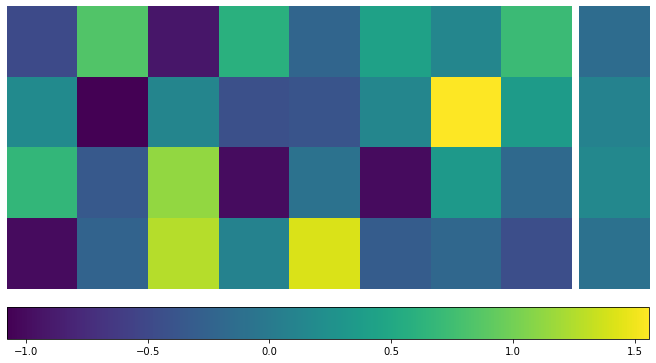

In [142]:
fig = vis_head(model, return_mode='plt_fig')

In [18]:
fig.savefig('/home/wangyh/01-Projects/03-my/figures/baseline/head.png', bbox_inches='tight')

In [146]:
test_data = data.MyDataset(os.path.join(Dataset_DIR, 'val'), transform=T)
print(len(test_data))
test_loader = DataLoader(test_data, batch_size=int(len(test_data) / 4))

8000


In [147]:
embeds = get_avg_embeds(model, test_loader)

100%|█████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.80it/s]


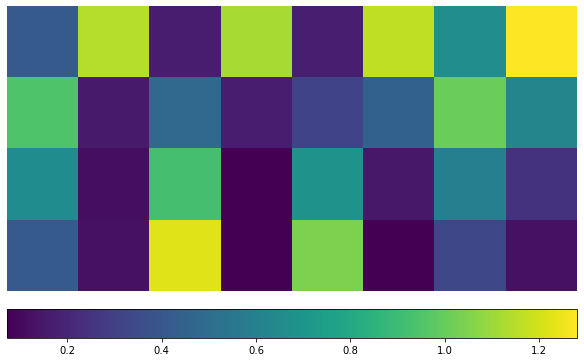

In [148]:
embed_fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 5))
im = ax.imshow(embeds, cmap='viridis')
ax.set_axis_off()
fig.colorbar(im, ax=ax, orientation='horizontal')
plt.show()

In [131]:
embed_fig.savefig('/home/wangyh/01-Projects/03-my/figures/baseline/avg_embed_edge_0.05.png', bbox_inches='tight')

In [59]:
x = np.array([str(i) for i in range(1, 5)])
y_edge = np.array([84.88, 78.84, 37.41, 28.27])
y_vertex = np.array([93.35, 90.7, 55.96, 44.62])

0.02	84.88	93.35
0.03 	78.84	90.7
0.05 	37.41	55.96
0.07 	28.27	44.62

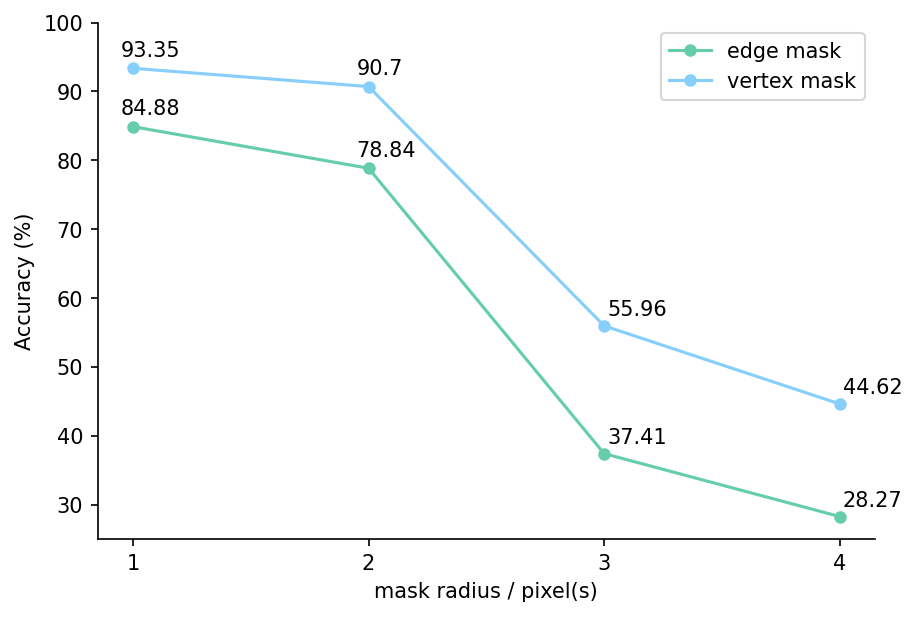

In [65]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, dpi=150)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(x, y_edge, marker='o', ms=5, label='edge mask', color='mediumaquamarine')
for x1, y1 in zip(x[:2], y_edge[:2]):
    ax.annotate(text=str(y1), xy=(x1, y1), xytext=(-12, 12), textcoords='offset pixels')
for x1, y1 in zip(x[2:], y_edge[2:]):
    ax.annotate(text=str(y1), xy=(x1, y1), xytext=(3, 10), textcoords='offset pixels')
ax.plot(x, y_vertex, marker='o', ms=5, label='vertex mask', color='lightskyblue')
for x2, y2 in zip(x[:2], y_vertex[:2]):
    ax.annotate(text=str(y2), xy=(x2, y2), xytext=(-12, 12), textcoords='offset pixels')
for x2, y2 in zip(x[2:], y_vertex[2:]):
    ax.annotate(text=str(y2), xy=(x2, y2), xytext=(3, 10), textcoords='offset pixels')
ax.legend(loc='best')
ax.set_xlabel('mask radius / pixel(s)')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim((25, 100))
plt.show()

In [66]:
fig.savefig('figures/baseline/mask.png', bbox_inches='tight', transparent=True, dpi=150)

In [ ]:
plt.annotate()